# Age Detection of Indian Actors - version 2.0

Version 2.0 adds to the previous version the following features/components/expts. :
 * Autoencoders
 * Advanced Activation Layers (LeakyReLU, PReLU, ELU)
 * Neural network architecture and hyper-parameters tuning

In [1]:
%matplotlib inline

In [2]:
## Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.misc import *

In [3]:
import os,sys
from PIL import Image
import cv2 #OpenCV library
from tqdm import tqdm

In [8]:
DATA_HOME_DIR = os.getcwd()
%pwd

'/Users/manikant/Documents/Analytics Vidhya/Age detection/Age-Detection-of-Indian-Actors'

## Reading the images and exploring the dataset

In [9]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [10]:
train.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [11]:
train.describe()

,ID,Class
count,19906,19906
unique,19906,3
top,5351.jpg,MIDDLE
freq,1,10804


In [12]:
train.Class.value_counts()

MIDDLE    10804
YOUNG      6706
OLD        2396
Name: Class, dtype: int64

In [13]:
## setting path for images
TRAIN_PATH = DATA_HOME_DIR + '/Train/'
TEST_PATH = DATA_HOME_DIR + '/Test/'

In [14]:
# function to read images as arrays
def read_image(img_path, mode = 'color', resize = False, size = 32):
    '''
    Default mode is : color(BGR) --> color(RGB)
    Other modes allowed are : 'grayscale' and 'include_opacity'
    '''
    if mode == 'grayscale':
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    elif mode == 'include_opacity':
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    else:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if resize == True:
        img = cv2.resize(img, (size, size))
    
    return img

In [15]:
## Storing all images as list of arrays
train_data = []
test_data = []

for img in tqdm(train['ID'].values):
    train_data.append(read_image(TRAIN_PATH + '{}'.format(img), resize = True, size = 32))
    
for img in tqdm(test['ID'].values):
    test_data.append(read_image(TEST_PATH + '{}'.format(img), resize = True, size = 32))

100%|██████████| 6636/6636 [00:07<00:00, 849.84it/s]


In [16]:
y_train = train['Class'].values

In [17]:
## Checking dimensions and aspect ratio of original images (without resizing)
rows = [x.shape[0] for x in (train_data+test_data)]
cols = [x.shape[1] for x in (train_data+test_data)]
channels = [x.shape[2] for x in (train_data+test_data)]
aspect_ratio = [x.shape[0]/x.shape[1] for x in (train_data+test_data)]

In [18]:
## Checking range of the dimesnions and aspect ratio
print("Min. and Max. rows = {} and {} respectively \nMin. and Max. cols = {} and {} respectively \nMin. and Max. channels = {} and {} respectively \nMin. and Max. aspect ratio = {} and {} respectively \n"
      .format(min(rows), max(rows), min(cols), max(cols), min(channels), max(channels), min(aspect_ratio), max(aspect_ratio)))

Min. and Max. rows = 32 and 32 respectively 
Min. and Max. cols = 32 and 32 respectively 
Min. and Max. channels = 3 and 3 respectively 
Min. and Max. aspect ratio = 1.0 and 1.0 respectively 



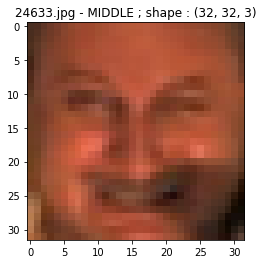

In [23]:
## Displaying random images without resizing
i = np.random.choice(np.arange(len(train_data)))

plt.title('{} - {} ; shape : {}'.format(train['ID'].values[i], y_train[i], train_data[i].shape))
plt.imshow(train_data[i])

In [24]:
## Scaling the images
X_train = np.array(train_data, np.float32) / 255.
X_test = np.array(test_data, np.float32) / 255.

In [25]:
# Encoding image labels into target variables (categorical)
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

ohe = OneHotEncoder(categorical_features = [0])
y_train = ohe.fit_transform(y_train.reshape(-1,1)).toarray()

In [26]:
y_train.shape

(19906, 3)

## Neural Network models - CNNs and its variants

In [30]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras.layers.advanced_activations import PReLU, LeakyReLU, ELU
from keras.optimizers import SGD
from keras.constraints import maxnorm

from keras import backend as K
K.set_image_dim_ordering('tf')

from keras.preprocessing import image

The keras backend is set to Theano in keras.json file, hence external conversion to Tensorflow is required. In case, the keras backend is TensorFlow, by default, this will not be required.
Use keras.backend.backend() or K.backend() to know the current backend.

We use Keras with Theano backend and 'tf' image_dim_ordering

In [32]:
os.environ['KERAS_BACKEND'] = 'theano'
reload(K)

NameError: name 'reload' is not defined

### Model 1 : CNN with BatchNorm + with/without Dropout

This model is the same as the ones used in the previous version of this project - Stacked CNN with BatchNormalization layers and Dropout. It can be used with either of the training methods which are shown below in the following sections.

A little bit of architecture tuning was tried out by throwing in a couple more Dropout/BatchNorm/Dense/Conv-Pool layers and/or by changing the dropout probability, number of filters, optimizer and other such hyperparameters to arrive at the below model 

In [33]:
model = Sequential([
        BatchNormalization(input_shape = (32,32,3)),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.3),
        Dense(384, activation='relu'),
        Dropout(0.6),
        Dense(3, activation='softmax')
        ])
model.compile(optimizer = 'adam' , loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [34]:
## Saving initial un-trained weights for future use
model.save_weights('initial_weights.h5')

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
__________

### Model 2 : Same as Model 1, but with image size resized to 128 and hence, more Conv-Pool layers

Quite a few experiments tried were around hyperparameter tuning of these CNN networks.

__Hyper-parameters__ : 
* *Batch Size ($32, 64, 128$ etc.)* : Batch sizes are selected keeping in mind the memory constraints of the hardware being used. Smaller batch sizes take a little longer to train, but are the only solution if our inputs are large. Different batch-sizes performed similarly, but a batch size of 32 turned out to be most suitable keeping all considerations in mind

* *Image size ($128X128, 64X64, 32X32$)* : Most input images are large enough (>> 32X32). Hence, using an input image size of 128X128 seems the best option. Resizing the images to 32X32 causes significant blurring in most of the images. This might affect the accuracy of the trained model. However, a network with input images of size 128X128 takes ~25x longer to train than a similar 32X32 network. I tried using 128X128 images, albeit with more Conv-Pool layers, but the resultant accuracy wasn't significantly better. Hence, switched to 32X32. Even networks with 64X64 sized images didn't result in a significant gain.

In [36]:
model = Sequential([
        BatchNormalization(input_shape = (128,128,3)),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.3),
        Dense(512, activation='relu'),
        Dropout(0.6),
        Dense(3, activation='softmax')
        ])
model.compile(optimizer = 'adam' , loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
## Saving initial un-trained weights for future use
model.save_weights('initial_weights.h5')

### Model 3 : Stacked CNN + BatchNorm/Dropout with Advanced Activation Layers

While a ReLU activation generally works with a stacked CNN model (there's enough literature to prove its superiority over sigmoid and tanh), since the input images were significantly downsampled and hence, highly blurred, I tried using other activation layers as an alternative to ReLU to see if we can arrive at better weights.

The other activations tried were :

* Leaky ReLU (with different alpha values)
* PReLU
* ELU

Leaky ReLU with a default alpha of 0.3 used in conjunction with Model 1's architecture helped reach ~75% test accuracy after 10-15 epochs

In [38]:
model = Sequential([
        BatchNormalization(input_shape = (32,32,3)),
        Convolution2D(32,(3,3), activation='linear'),
        LeakyReLU(alpha = 0.3),
        BatchNormalization(),
        Convolution2D(32,(3,3), activation='linear'),
        LeakyReLU(alpha = 0.3),
        BatchNormalization(),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='linear'),
        LeakyReLU(alpha = 0.3),
        BatchNormalization(),
        Convolution2D(64,(3,3), activation='linear'),
        LeakyReLU(alpha = 0.3),
        BatchNormalization(),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.3),
        Dense(384, activation='linear'),
        LeakyReLU(alpha = 0.3),
        Dropout(0.6),
        Dense(3, activation='softmax')
        ])
model.compile(optimizer = 'adam' , loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
## Saving initial un-trained weights for future use
model.save_weights('initial_weights.h5')

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_13 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 32)        128       
__________

## Training the model

The below section contains a function for learning rate decay / annealing along with 3 different ways of training.

* Without data augmentation - Doesn't work well mostly. Overfits easily with most architectures
* Data augmentation without cross-validation
* Data augmentation with cross-validation

Data augmentation helps in reducing overfitting and also helps in improving the accuracy for this particular problem, since most of the images are noisy (affected by blur, poor illumination, scaling effects etc.). I separated the cross-validation part so as to quickly try out different models with only one validation set. Once we finalize on a few architectures/set of hyperparameters, learning rate schedule, we can perform cross-validation to get a better estimation of validation accuracy.

In [41]:
## Building a custom function for learning rate decay/annealing
def lr_decay(start, stop, div_step_1, div_step_2 = 2) :
    k = 1
    while start >= stop:
        yield start
        if k==1 :
            start/= div_step_1
        else : start/= div_step_2
        k = k * -1

### 1. Without data augmentation

When data augmentation is not required, we can simply use the fit method

In [42]:
# Training the model
model.fit(X_train, y_train, batch_size=32, epochs=2, validation_split=0.2)

Train on 15924 samples, validate on 3982 samples
Epoch 1/2
15924/15924 [==============================] - 84s 5ms/step - loss: 1.2725 - acc: 0.5794 - val_loss: 0.8078 - val_acc: 0.6374
Epoch 2/2
15924/15924 [==============================] - 87s 5ms/step - loss: 0.7821 - acc: 0.6576 - val_loss: 0.6991 - val_acc: 0.6986


In [43]:
model.optimizer.lr /= 10

In [44]:
## Saving weights as a form of model checkpointing
model.save_weights('age-detection_weights.h5')

### 2. Data augmentation without cross-validation

Note : 

* When using networks with large images(e.g. 128 X 128), batch_size for train and validation set should be kept low, so as to fit the images in the RAM/vRAM

* Each epoch with 128X128 images took ~4800-5200 secs, which makes it infeasible to train for a long time. Either use a faster GPU, or resize all images to 32X32 and train the model on blurred images


In [45]:
from sklearn.cross_validation import train_test_split
X_trn, X_valid, y_trn, y_valid = train_test_split(X_train, y_train, test_size = 0.2)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [46]:
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, shear_range=0.25,
                               height_shift_range=0.1, zoom_range=0.2, horizontal_flip = True)
batches = gen.flow(X_trn, y_trn, batch_size = 64)
val_batches = gen.flow(X_valid, y_valid, batch_size = 128)

In [47]:
model.optimizer.lr = 0.001

In [48]:
model.fit_generator(batches, (X_trn.shape[0]//batches.batch_size), epochs=1,
                    validation_data = val_batches, validation_steps = (X_valid.shape[0]//val_batches.batch_size))

Epoch 1/1
248/248 [==============================] - 76s 308ms/step - loss: 0.7704 - acc: 0.6627 - val_loss: 0.7235 - val_acc: 0.6802


In [49]:
model.optimizer.lr /= 10

In [50]:
model.fit_generator(batches, steps_per_epoch = (X_trn.shape[0]//batches.batch_size), epochs=2,
                    validation_data = val_batches, validation_steps = (X_valid.shape[0]/val_batches.batch_size))

Epoch 1/2
248/248 [==============================] - 87s 349ms/step - loss: 0.7417 - acc: 0.6742 - val_loss: 0.7474 - val_acc: 0.6625
Epoch 2/2
248/248 [==============================] - 89s 360ms/step - loss: 0.7360 - acc: 0.6732 - val_loss: 0.7219 - val_acc: 0.6881


 LR decay can also be used for better training

In [53]:
for i in lr_decay(0.005, 0.0002, 2, 5):
    model.optimizer.lr = i
    print("Learning rate = " + str(i))
    model.fit_generator(batches, (X_trn.shape[0]//batches.batch_size), epochs=1,
                    validation_data = val_batches, validation_steps = (X_valid.shape[0]//val_batches.batch_size))

Learning rate = 0.005
Epoch 1/1
248/248 [==============================] - 77s 310ms/step - loss: 0.7190 - acc: 0.6890 - val_loss: 0.7313 - val_acc: 0.6880
Learning rate = 0.0025
Epoch 1/1
248/248 [==============================] - 99s 401ms/step - loss: 0.7141 - acc: 0.6937 - val_loss: 0.6833 - val_acc: 0.7034
Learning rate = 0.0005
Epoch 1/1
248/248 [==============================] - 90s 365ms/step - loss: 0.7162 - acc: 0.6932 - val_loss: 0.6869 - val_acc: 0.7044
Learning rate = 0.00025
Epoch 1/1
248/248 [==============================] - 97s 390ms/step - loss: 0.7057 - acc: 0.6992 - val_loss: 0.7088 - val_acc: 0.7029


In [54]:
## Saving weights as a form of model checkpointing
model.save_weights('leakyReLU_age-detection_weights.h5')

### 3. Data augmentation with cross-validation

In [64]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 102)
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=102)
fold_num = 1

In [ ]:
for train_idx, val_idx in skf.split(X_train,np.zeros(shape=(X_train.shape[0], 1))):
    print("Fitting fold %d" %fold_num)
    
    # Data augmentation image generator
    gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, shear_range=0.25,
                               height_shift_range=0.1, zoom_range=0.2, horizontal_flip = True)
    batches = gen.flow(X_train[train_idx], y_train[train_idx], batch_size = 32)
    val_batches = gen.flow(X_train[val_idx], y_train[val_idx], batch_size = 64)
    
    # Fitting the model
    model.fit_generator(batches, steps_per_epoch = (X_trn.shape[0]//batches.batch_size), epochs=3,
                    validation_data = val_batches, validation_steps = (X_valid.shape[0]//val_batches.batch_size))
    
    # Recompiling the model with initial weights
    model.load_weights('initial_weights.h5')
    
    fold_num += 1


Fitting fold 1
Epoch 1/3
497/497 [==============================] - 87s 176ms/step - loss: 0.7653 - acc: 0.6694 - val_loss: 0.7457 - val_acc: 0.6729
Epoch 2/3
497/497 [==============================] - 84s 170ms/step - loss: 0.7451 - acc: 0.6780 - val_loss: 0.6980 - val_acc: 0.7019
Epoch 3/3
497/497 [==============================] - 84s 169ms/step - loss: 0.7229 - acc: 0.6916 - val_loss: 0.6946 - val_acc: 0.6941
Fitting fold 2
Epoch 1/3
497/497 [==============================] - 99s 199ms/step - loss: 3.1175 - acc: 0.5272 - val_loss: 0.8606 - val_acc: 0.6139
Epoch 2/3
497/497 [==============================] - 140s 282ms/step - loss: 0.9190 - acc: 0.5951 - val_loss: 0.7933 - val_acc: 0.6502
Epoch 3/3
270/497 [===============>..............] - ETA: 58s - loss: 0.8487 - acc: 0.6307

### Autoencoders with ConvNets

In [29]:
## Building the autoencoder pipeline

input_img = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (8, 4, 4, 3) i.e. 384-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding = 'same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [30]:
## Composing the autoencoder model and compiling it
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy') # can change optimizer to 'adam'

In [31]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 8)           1160      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 8)           0         
__________

In [ ]:
# Use Tensorboard to visualize the training process
# Run this in the terminal
!tensorboard --logdir = /tmp/autoencoder

In [41]:
from keras.callbacks import TensorBoard

In [32]:
## Fitting the autoencoder model
autoencoder.fit(X_train, X_train,
                epochs= 10,
                batch_size= 64,
                shuffle= True,
                validation_data= (X_test, X_test))
                #callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Train on 19906 samples, validate on 6636 samples
Epoch 1/10
19906/19906 [==============================] - 122s - loss: 0.6284 - val_loss: 0.6159
Epoch 2/10
19906/19906 [==============================] - 120s - loss: 0.6025 - val_loss: 0.5934
Epoch 3/10
19906/19906 [==============================] - 122s - loss: 0.5946 - val_loss: 0.5942
Epoch 4/10
19906/19906 [==============================] - 122s - loss: 0.5913 - val_loss: 0.5889
Epoch 5/10
19906/19906 [==============================] - 124s - loss: 0.5891 - val_loss: 0.5887
Epoch 6/10
19906/19906 [==============================] - 123s - loss: 0.5873 - val_loss: 0.5862
Epoch 7/10
19906/19906 [==============================] - 125s - loss: 0.5860 - val_loss: 0.5875
Epoch 8/10
19906/19906 [==============================] - 125s - loss: 0.5852 - val_loss: 0.5847
Epoch 9/10
19906/19906 [==============================] - 124s - loss: 0.5844 - val_loss: 0.5851
Epoch 10/10
19906/19906 [==============================] - 123s - loss: 0.5839

In [51]:
autoencoder.fit(X_train, X_train,
                epochs= 3,
                batch_size= 128,
                shuffle= True,
                validation_data= (X_test, X_test))

Train on 19906 samples, validate on 6636 samples
Epoch 1/3
19906/19906 [==============================] - 109s - loss: 0.5836 - val_loss: 0.5829
Epoch 2/3
19906/19906 [==============================] - 109s - loss: 0.5834 - val_loss: 0.5834
Epoch 3/3
19906/19906 [==============================] - 116s - loss: 0.5833 - val_loss: 0.5835


In [56]:
X_test.shape

(6636, 32, 32, 3)

In [64]:
decoded_imgs = autoencoder.predict(X_test)

## Making predictions on test set

In [82]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis= 1)

In [83]:
# Converting predicted category numbers to predicted labels
unique_labels = np.unique(train['Class'].tolist())
pred_labels = unique_labels[predictions]

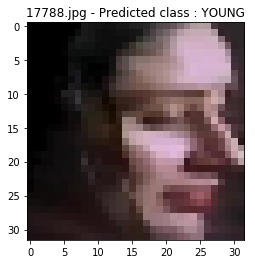

In [45]:
## Let's see what our classifier predicts on test images
# Random predictions
i = np.random.choice(np.arange(len(test_data)))
plt.title('{} - Predicted class : {}'.format(test['ID'].values[i], pred_labels[i]))
plt.imshow(test_data[i])

In [84]:
# Prepare submission file
subm = pd.DataFrame({'Class':pred_labels, 'ID':test.ID})
subm.to_csv('sub03_2_leakyReLU.csv', index=False)